# Recommender System (with ALS) - Movies!

#########################

Rob Rappa
12/28/2018

#########################

References

1) https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

2) https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/

3) https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/

In [13]:
#########################
# IMPORT
#########################

import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [14]:
#RATINGS
ratings_raw = pd.read_table('ml-latest-small/ratings.csv', sep=',', header=0) #

ratings_raw.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [15]:
#MOVIES
#movie_headers = ['movie_id', 'title', 'genres']
movies_raw = pd.read_table('ml-latest-small/movies.csv',sep=',', header=0)

movies_raw.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
#########################
# BASIC ANALYSIS
#########################

#Key Stats

#Number of unique users/movies
num_unqiue_users = ratings_raw.userId.unique().shape[0]
num_unique_movies = ratings_raw.movieId.unique().shape[0]

#Number of total users/movies
num_total_users = ratings_raw.userId.max()
num_total_movies = ratings_raw.movieId.max()

#Number of min ratings per user
num_min_ratings = min(ratings_raw.groupby('userId').size())


#Print Stats
print('Number of unique users: ' + str(num_unqiue_users))
print('Number of unique movies: ' + str(num_unique_movies))
print('Highest ID user: ' + str(num_total_users))
print('Highest ID movie: ' + str(num_total_movies))
print('Min number of ratings per user: ' + str(num_min_ratings))

Number of unique users: 610
Number of unique movies: 9724
Highest ID user: 610
Highest ID movie: 193609
Min number of ratings per user: 20


In [18]:
#########################
# PREP DATA
#########################

#Initialize User-Movies matrix
ratings = np.zeros((num_total_users, num_total_movies))

print(ratings)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
#Create a User x Movies matrix, where the entries are the ratings
for user_movie_rating in ratings_raw.itertuples():

    #Pull out key components
    idx_user   = int(user_movie_rating[1])
    idx_movie  = int(user_movie_rating[2])
    idx_rating = int(user_movie_rating[3])
    
    #Enter row into new matrix
    ratings[idx_user-1,idx_movie-1] = idx_rating
    
print(ratings)

[[4. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 2. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]


In [20]:
#########################
# BASIC DATA ANALYSIS
#########################

sparsity = float(len(ratings.nonzero()[0])) / (num_total_users * num_total_movies)

print('Sparsity of the user-rating matrix is: {:4.2f}%'.format(sparsity*100))

Sparsity of the user-rating matrix is: 0.08%


In [21]:
#########################
# BUILD TEST/TRAIN SETS
#########################

def train_test_split(ratings, num_nonzero_ratings):
    
    #Default num_nonzero_ratings to *10*
    num_nonzero_ratings = 10
    
    #The training set should have most of the original ratings.
    #  We should copy the original ratings to the training set.
    #  Then, we should take *10* of the non-zero ratings from each user and set them to 0 in the training set.
    #  This will enable us to test them later on.
    train = ratings.copy()

    #The testing set should have only a small amomunt of the original ratings.
    #  We should set the initial testing set to 0.
    #  Then, we should take *10* of the non-zero ratings from each user.
    test = np.zeros(ratings.shape)
    
    #Identify the 10 non-zero ratings from each user
    for user in range(ratings.shape[0]):
        
        idx_user_nonzero_rating = np.random.choice(ratings[user,:].nonzero()[0],size=num_nonzero_ratings,replace=False)
        
        #Training set: set the 10 nonzero rating indices to 0
        train[user,idx_user_nonzero_rating] = 0.
        
        #Testing set: only input the 10 nonzero ratings
        test[user,idx_user_nonzero_rating] = ratings[user,idx_user_nonzero_rating]
    
    #Confirm that the training and testing sets are disjointTest and training are truly disjoint
    # By doing element-wise multiplication of the train and test sets, each cell should be zero
    # If this isn't true, throw an error
    assert(np.all((train * test) == 0)) 
    
    #Return values
    return train, test


In [97]:
#########################
# MATRIX FACTORIZATION
#  CLASS USING ALS
#########################

from numpy.linalg import solve

class MF_with_ALS():
    
    def __init__( self                     #Self
                 ,ratings                  #User x Item rating matric
                 ,num_factors=40           #Number of latent factors       
                 ,reg_user=0.0             #Regularization term for Users x Latent Facors
                 ,reg_item=0.0             #Regularization term for Movies x Latent Facors
                 ,verbose=False):          #Whether to print out the training process
        
        #Initialize
        self.ratings   = ratings           #User x Item rating matric
        self.num_users = ratings.shape[0]  #Number of users
        self.num_items = ratings.shape[1]  #Number of items
        self.num_factors = num_factors     #Number of latent factors       
        self.reg_user  = reg_user          #Regularization term for Users x Latent Facors
        self.reg_item  = reg_item          #Regularization term for Movies x Latent Facors
        self._v        = verbose           #Whether to print out the training process
        

    def als_step( self                     #Self
                 ,latent_vectors           #User x Latent Factor Matrix (or Item x Latent Factor)
                 ,fixed_vecs               #Item x Latent Factor Matrix (or User x Latent Factor)
                 ,ratings                  #User x Item Ratings Matrix
                 ,reg_term                 #Regularization factors
                 ,als_type='user'):
        
        #Overall
        #Single step within ALS.
        #If 'type' = 'user', then keep items fixed and solve for the User x Latent Factor matrix.
        #If 'type' = 'item', then keep users fixed and solve for the Item x Latent Factor matrix.
        
        if als_type == 'user':
            
            #Precompute YTY since it will speed computation later
            YTY = fixed_vecs.T.dot(fixed_vecs)

            #Shape of I (with lambdas on diagonal) = first dimension of YTY
            lambdaI = np.eye(YTY.shape[0]) * reg_term
            
            #Solve for each row in the User x Latent Factor matrix
            #Solve using "solver", which solves for x in the following equation: Ax = b
            #Solves for each user: xT * (YTY + lambdaI) = r * Y
            for user in range(latent_vectors.shape[0]):
                
                #Check  dimensions:         ((k*i)*(i*k) + (k*k))      ((1*i)*(i*k))
                latent_vectors[user, :] = solve((YTY + lambdaI), self.ratings[user, :].dot(fixed_vecs))
                
        elif als_type == 'item':

            #Precompute XTX since it will speed computation later
            XTX = fixed_vecs.T.dot(fixed_vecs)

            #Shape of I (with lambdas on diagonal) = first dimension of XTX            
            lambdaI = np.eye(XTX.shape[0]) * reg_term

            #Solve for each row in the Item x Latent Factor matrix
            #Solve using "solver", which solves for x in the following equation: Ax = b
            #Solves for each user: yT * (XTX + lambdaI) = r * X            
            for item in range(latent_vectors.shape[0]):

                #Check  dimensions:     ((k*u)*(u*k) + (k*k))      ((1*u)*(u*k))                
                latent_vectors[item, :] = solve((XTX + lambdaI), self.ratings[:, item].T.dot(fixed_vecs))
                
        return latent_vectors
    
    def train_withInitialization(self, num_iter=10):
        
        #Initialize latent vectors with random numbers
        self.user_vector = np.random.random((self.num_users, self.num_factors))
        self.item_vector = np.random.random((self.num_items, self.num_factors))        
        
        self.train_withoutInitialization(num_iter)
        
    def train_withoutInitialization(self, num_iter):
    
        counter=1
        
        #Run ALS Steps        
        for counter in range(num_iter+1):
            
            #Print current progress
            if counter%10==1 and self._v==True:
                print('\tCurrent Iteration: {}'.format(counter))
                        
            #ALS Step 1 - Optimize User x Latent Factors
            self.user_vector = self.als_step( self.user_vector  #Latent Vectors we're optimizing
                                             ,self.item_vector  #Fixed Vector
                                             ,ratings           #Ratings
                                             ,self.reg_user     #Regularization term for users
                                             ,als_type='user')  #ALS type
                                             
            
            #ALS Step 2 - Optimize Item x Latent Factors            
            self.item_vector = self.als_step( self.item_vector  #Latent Vectors we're optimizing
                                             ,self.user_vector  #Fixed Vector
                                             ,ratings           #Ratings
                                             ,self.reg_user     #Regularization term for users
                                             ,als_type='item')  #ALS type     
    
    def predict(self):
        
        #Initialize predictions
        self.predictions = np.zeros((self.user_vector.shape[0],self.item_vector.shape[0]))
        
        #Generate predictions for every user and item
        for user in range(self.user_vector.shape[0]):
            for item in range(self.item_vector.shape[0]):
                self.predictions[user,item] = self.user_vector[user,:].dot(self.item_vector[item,:].T)
                
                #if item%1000==0:
                    #print('User {} and Item {}: {}'.format(user, item, predictions[user,item]))
        return self.predictions
        
            
    def calculate_learning_curve(self, num_iteration_array, test_set):
        
        #Sort the number of iterations we want to review
        num_iteration_array.sort()
        
        #Create empty arrays for training and testing MSE
        self.mse_train = []
        self.mse_test  = []
        
        #Initialize a variable tracking the difference in the 
        # number of iterations done and the next benchmark
        # we want to get to
        current_iterations_done = 0
        
        #Loop through iterations and store MSEs
        
        for (i, num_iterations) in enumerate(num_iteration_array):
            
            #Print progress
            #  Specifically, print the last items in the
            #  train and test MSE vectors
            if self._v == True:
                print('Iteration {}'.format(num_iterations))            
            
            #Train
            # Note: if it's the first iteration, then need to initialize
            #       if it's after the first iteration, it's already initialized 
            #       so just run it the additional difference times
            if i==0:
                self.train_withInitialization(num_iterations-current_iterations_done)
            else: 
                self.train_withoutInitialization(num_iterations-current_iterations_done)
            
            #Predict on All Users and Items
            self.predictions = self.predict()
            #print(self.predictions)
            
            #Get errors on All Users and Items
            self.mse_train += [get_mse(self.predictions, self.ratings)]
            self.mse_test  += [get_mse(self.predictions, test_set)]
            
            #Print progress
            #  Specifically, print the last items in the
            #  train and test MSE vectors
            if self._v == True:
                print('Train MSE: ' + str(self.mse_train[-1]))
                print('Test MSE: ' + str(self.mse_test[-1]))
                
            current_iterations_done = num_iterations  
    

In [99]:
#########################
# MSE HELPER
#########################

def get_mse(pred, actual):
    
    #Debug shapes
    #print(pred.shape)
    #print(actual.shape)
        
    #Remove nonzero terms from predictions and actuals
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()

    #Return the errors
    return mean_squared_error(pred, actual)

In [100]:
#########################
# VISUALIZE ERRORS
#########################

def plot_learning_curve(model, iter_array):

    #Plot the Training MSE
    plt.plot(iter_array, model.mse_train, label='Training', linewidth=5)

    #Plot the Test MSE
    plt.plot(iter_array, model.mse_test, label='Test', linewidth=5)

    #Define plot elements
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

Iteration 1
	Current Iteration: 1
(610, 100000)
(610, 100000)
(610, 100000)
(610, 100000)
Train MSE: 5.069813941013079
Test MSE: 10.130533183236624
Iteration 5
	Current Iteration: 1
(610, 100000)
(610, 100000)
(610, 100000)
(610, 100000)
Train MSE: 4.882572934708933
Test MSE: 9.944144354522106


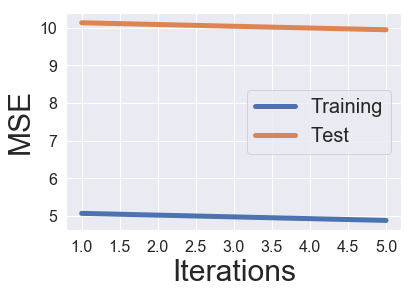

In [98]:
#########################
# MAIN - RUN THE MODEL
#########################

#Make the ratings matrix smaller
ratings_sub = ratings[:1000,:100000]

#Create the data
train, test = train_test_split(ratings_sub,10)

#Build the model
#Use: 
movie_ALS_model = MF_with_ALS(train, num_factors=25,reg_user=0.0, reg_item=0.0,verbose=True)

#Build the number of iterations array
iterations_array = [1 , 5] #, 10, 25, 50]

#Build the learning curve
movie_ALS_model.calculate_learning_curve(iterations_array, test)

#Plot the learning curve
plot_learning_curve(movie_ALS_model, iterations_array)

In [106]:
#########################
# GRID SEARCH
# TO FIND BEST MODEL
#########################

#Identify Grids
grid_latent_factors = [5, 10, 20, 40, 80]
grid_reg_param = [0.1, 1., 10., 100.]
grid_reg_param.sort()
grid_iteration_array = [1, 5, 25, 50, 100]

#Create 'Best Params' Dictionary
#Store temporary values
best_params = {}
best_params['num_latent_factors'] = grid_latent_factors[0]
best_params['reg_param'] = grid_reg_param[0]
best_params['num_iterations'] = 0
best_params['mse_train'] = np.inf
best_params['mse_test'] = np.inf
best_params['model'] = None

for cur_num_latent_fact in grid_latent_factors:
    print('Number of Latent Factors: {}'.format(cur_num_latent_fact))
    
    for cur_reg_param in grid_reg_param:
        print('Regularization: {}'.format(cur_reg_param))
        
        cur_mf_als_model = MF_with_ALS(train, num_factors=cur_num_latent_fact, reg_user=cur_reg_param, reg_item=cur_reg_param)
        
        cur_mf_als_model.calculate_learning_curve(grid_iteration_array, test)
        
        min_mse_iter_idx = np.argmin(cur_mf_als_model.mse_test)
        
        #If the current model yields a lower Test MSE than seen before, 
        #then store it as the best model
        if cur_mf_als_model.mse_test[min_idx] < best_params['mse_test']:
            best_params['num_latent_factors'] = cur_num_latent_fact
            best_params['reg_param'] = cur_reg_param
            best_params['num_iterations'] = grid_iteration_array[min_mse_iter_idx]
            best_params['mse_train'] = cur_mf_als_model.train_mse[min_mse_iter_idx]
            best_params['mse_test'] = cur_mf_als_model.test_mse[min_mse_iter_idx]
            best_params['model'] = cur_mf_als_model
            print('New Optimal Hyperparameters')
            print(pd.Series(best_params))

Number of Latent Factors: 5
Regularization: 0.1


NameError: name 'min_idx' is not defined